In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install patchify

In [ ]:
import pandas as pd
import numpy as np
import cv2 as cv
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import os
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout, Conv2DTranspose, Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from PIL import Image
import random



```
# This is formatted as code
```

#Preprocessing

In [ ]:
def extraction(filepath):
    filenames = os.listdir(filepath)
    filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    f = []
    for fn in filenames:
        f.append(fn.split('.')[0])
    return f
def load_shapes(filenames, filepath):
    shapes=[]
    for i in range(len(filenames)):
        if filenames[i][:5] == 'image':
            img_path = f'{filepath}/{filenames[i]}.jpg'
        else:
            img_path = f'{filepath}/{filenames[i]}.png'
        img = cv.imread(img_path)
        if img is not None:
            shapes.append(img.shape)
    return set(shapes)

def load_images(filenames, filepath):
    for i in range(len(filenames)):
        img_path = f'{filepath}/{filenames[i]}.jpg'
        img = cv.imread(img_path)
        #print(img_path,img.shape)
        img_shape = img.shape
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            #plt.imshow(img)
            #plt.show()
            initial_image_dataset.append(img)
        else:
            print('break')
            break

"""
def load_images(filenames, filepath):
    for i in range(len(filenames)):
        img_path = f'{filepath}/{filenames[i]}.jpg'
        img = cv.imread(img_path)
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
            blur = cv.GaussianBlur(gray, (21, 21), 0)
            _, threshold = cv.threshold(blur, 240, 255, cv.THRESH_BINARY_INV)
            kernel = np.ones((5, 5), np.uint8)
            dilated = cv.dilate(threshold, kernel, iterations=2)
            result = cv.inpaint(img, dilated, 3, cv.INPAINT_TELEA)
            initial_image_dataset.append(result)
        else:
            print(f'Image {filenames[i]} not found.')
            break
"""
def load_mask(filenames, filepath):
    for i in range(len(filenames)):
        mask_path = f'{filepath}/{filenames[i]}.png'
        mask = cv.imread(mask_path)
        mask_shape = mask.shape
        if mask is not None:
            mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
            initial_mask_dataset.append(mask)
        else:
            print(f'Failed to load mask: {mask_path}')
            continue

In [ ]:
filenames_01 = extraction('/content/drive/MyDrive/new_dataset_working/temp_mask')
filenames_01

['img_1', 'img_8', 'img_17']

In [ ]:
initial_mask_dataset=[]
initial_image_dataset=[]
load_images(filenames_01, '/content/drive/MyDrive/new_dataset_working/temp_training_img')
load_mask(filenames_01, '/content/drive/MyDrive/new_dataset_working/temp_mask')

In [ ]:
image_patch_size = 256
image_dataset_after_pil = []
test__image_dataset_after_pil = []

for i in initial_image_dataset:
    size_x = ((i.shape[1]) // image_patch_size) * image_patch_size
    size_y = ((i.shape[0]) // image_patch_size) * image_patch_size
    img = Image.fromarray(i)
    img = img.crop((0, 0, size_x, size_y))
    img = np.array(img)
    img_shape = img.shape
    print(img_shape)
    image_dataset_after_pil.append(img)
pathcified_image_dataset = []
for i in image_dataset_after_pil:
    pathcified_image_dataset.append(patchify(i, (image_patch_size, image_patch_size, 3), step=image_patch_size))
minmaxscaler = MinMaxScaler()
standardScaler = StandardScaler()
individual_image_dataset = []
for img in pathcified_image_dataset:
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            individual_patched_img = img[i, j, :, :]
            individual_patched_img = minmaxscaler.fit_transform(individual_patched_img.reshape(-1, individual_patched_img.shape[-1])).reshape(individual_patched_img.shape)
            individual_image_dataset.append(individual_patched_img[0])
mask_dataset_after_pil = []
for i in initial_mask_dataset:
    size_x = (i.shape[1] // image_patch_size) * image_patch_size
    size_y = (i.shape[0] // image_patch_size) * image_patch_size
    mask = Image.fromarray(i)
    mask = mask.crop((0, 0, size_x, size_y))
    mask = np.array(mask)
    mask_shape = mask.shape
    mask_dataset_after_pil.append(mask)
patchified_mask_dataset = []

for i in mask_dataset_after_pil:
    patchified_mask_dataset.append(patchify(i, (image_patch_size, image_patch_size, 3), step=image_patch_size))
individual_mask_dataset = []
for img in patchified_mask_dataset:
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            individual_patched_mask = img[i, j, :, :]
            individual_mask_dataset.append(individual_patched_mask[0])

individual_image_dataset = np.array(individual_image_dataset)
individual_mask_dataset = np.array(individual_mask_dataset)
print(individual_image_dataset.shape)
print(individual_mask_dataset.shape)

(4096, 8192, 3)
(4096, 8192, 3)
(4096, 8192, 3)
(1536, 256, 256, 3)
(1536, 256, 256, 3)


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
class_road = (10,53,239)
def rgb_to_label(label):
    label_segment = np.zeros(label.shape[:2], dtype=np.uint8)
    label_segment[np.all(label == class_road, axis=-1)] = 1
    return label_segment
labels = []
for i in range(len(individual_mask_dataset)):
    label = rgb_to_label(individual_mask_dataset[i])
    labels.append(label)
print(labels[0].shape)
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
master_image_dataset = individual_image_dataset
master_mask_dataset = labels
X_train, X_test, y_train, y_test = train_test_split(master_image_dataset, master_mask_dataset, test_size=0.15, random_state=100,shuffle=True)

(256, 256)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1305, 256, 256, 3)
(1305, 256, 256, 1)
(231, 256, 256, 3)
(231, 256, 256, 1)


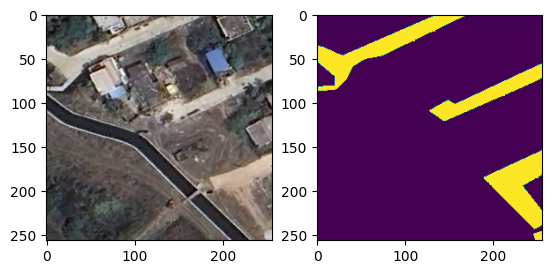

In [ ]:
qj =55
plt.subplot(1, 2, 1)
plt.imshow(X_test[qj])
plt.subplot(1, 2, 2)
plt.imshow(y_test[qj])
plt.show()

# Model loading and training unet++

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def jaccard_coef(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + 1.0) / (union + 1.0)

def iou_metric(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + 1e-10) / (union + 1e-10)

def dice_coefficient(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + 1e-10) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + 1e-10)

import tensorflow as tf
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

def precision_metric(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat * y_pred_flat, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred_flat, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall_metric(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat * y_pred_flat, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))


import tensorflow as tf
from tensorflow.keras import backend as K

def mean_average_precision(y_true, y_pred, thresholds=None):
    if thresholds is None:
        thresholds = tf.range(0.0, 1.1, 0.1)

    # Flatten y_true and y_pred
    y_true_flat = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_flat = tf.reshape(y_pred, [-1])

    average_precisions = []

    for threshold in thresholds:
        y_pred_thresh = tf.cast(y_pred_flat > threshold, tf.float32)

        true_positives = K.sum(y_true_flat * y_pred_thresh)
        predicted_positives = K.sum(y_pred_thresh)
        possible_positives = K.sum(y_true_flat)

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        average_precisions.append(precision)

    return K.mean(tf.stack(average_precisions))



In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
from tensorflow.keras.models import Model


metrics = [
    "accuracy",
    #jaccard_coef,
    iou_metric,
    dice_coefficient,
    precision_metric,
    recall_metric,
    mean_average_precision
]

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_plus_plus(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1_0 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_0)

    conv2_0 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_0)

    conv3_0 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_0)

    conv4_0 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_0)

    conv5_0 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)

    # Decoder with dense connections
    up4_0 = UpSampling2D(size=(2, 2))(conv5_0)
    conv4_1 = concatenate([up4_0, conv4_0])
    conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4_1)

    up3_0 = UpSampling2D(size=(2, 2))(conv4_1)
    conv3_1 = concatenate([up3_0, conv3_0])
    conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3_1)

    up2_0 = UpSampling2D(size=(2, 2))(conv3_1)
    conv2_1 = concatenate([up2_0, conv2_0])
    conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2_1)

    up1_0 = UpSampling2D(size=(2, 2))(conv2_1)
    conv1_1 = concatenate([up1_0, conv1_0])
    conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1_1)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(conv1_1)

    model = Model(inputs, outputs)

    return model

model_01 = unet_plus_plus(input_shape=(256, 256, 3), num_classes=1)
model_01.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
model_01.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 1024)   │              0 │ conv2d_4[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1536)   │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 512)    │      7,078,400 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 64, 64, 512)    │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 64, 64, 768)    │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)    

 Total params: 15,671,937 (59.78 MB)

 Trainable params: 15,671,937 (59.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=2, restore_best_weights=True)
history_01 = model_01.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=4, epochs=100, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 130s 366ms/step - accuracy: 0.9411 - dice_coefficient: 0.0489 - iou_metric: 0.0254 - loss: 0.2434 - mean_average_precision: 0.0147 - precision_metric: 6.7915e-04 - recall_metric: 0.0194 - val_accuracy: 0.9611 - val_dice_coefficient: 0.0720 - val_iou_metric: 0.0378 - val_loss: 0.1407 - val_mean_average_precision: 0.0173 - val_precision_metric: 0.0000e+00 - val_recall_metric: 0.0000e+00
Epoch 2/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 116s 353ms/step - accuracy: 0.9620 - dice_coefficient: 0.0689 - iou_metric: 0.0361 - loss: 0.1453 - mean_average_precision: 0.0184 - precision_metric: 0.0000e+00 - recall_metric: 0.0000e+00 - val_accuracy: 0.9611 - val_dice_coefficient: 0.0855 - val_iou_metric: 0.0455 - val_loss: 0.1391 - val_mean_average_precision: 0.0369 - val_precision_metric: 0.0000e+00 - val_recall_metric: 0.0000e+00
Epoch 3/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 114s 348ms/step - accuracy: 0.9603 - dice_coefficient: 0.0785 - iou_metric: 0.0414 - loss: 0.1469

In [ ]:
"""
Epoch 39/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 49s 338ms/step
accuracy: 0.9763 - dice_coefficient: 0.7378 - iou_metric: 0.5887 - loss: 0.0576 - mean_average_precision: 0.6765 - precision_metric: 0.8338 - recall_metric: 0.8025
val_accuracy: 0.9480 - val_dice_coefficient: 0.4779 - val_iou_metric: 0.3254 - val_loss: 0.2032 - val_mean_average_precision: 0.5058 - val_precision_metric: 0.6039 - val_recall_metric: 0.4657
Epoch 26/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 326ms/step - accuracy: 0.9427 - dice_coefficient: 0.3563 - iou_metric: 0.2219 - loss: 0.1506 - mean_average_precision: 0.5109 - precision_metric: 0.6887 - recall_metric: 0.3055
val_accuracy: 0.9431 - val_dice_coefficient: 0.3616 - val_iou_metric: 0.2235 - val_loss: 0.1481 - val_mean_average_precision: 0.4862 - val_precision_metric: 0.6358 - val_recall_metric: 0.3522
"""
"""
327/327 ━━━━━━━━━━━━━━━━━━━━ 138s 334ms/step - accuracy: 0.9748 - dice_coefficient: 0.4126 - iou_metric: 0.2803 - loss: 0.0689 - mean_average_precision: 0.4924 - precision_metric: 0.6433 - recall_metric: 0.4373 - val_accuracy: 0.9706 - val_dice_coefficient: 0.3935 - val_iou_metric: 0.2654 - val_loss: 0.0833 - val_mean_average_precision: 0.4352 - val_precision_metric: 0.5435 - val_recall_metric: 0.4656
"""

'\n327/327 ━━━━━━━━━━━━━━━━━━━━ 138s 334ms/step - accuracy: 0.9748 - dice_coefficient: 0.4126 - iou_metric: 0.2803 - loss: 0.0689 - mean_average_precision: 0.4924 - precision_metric: 0.6433 - recall_metric: 0.4373 - val_accuracy: 0.9706 - val_dice_coefficient: 0.3935 - val_iou_metric: 0.2654 - val_loss: 0.0833 - val_mean_average_precision: 0.4352 - val_precision_metric: 0.5435 - val_recall_metric: 0.4656\n'

In [ ]:
model_01.save('model_01.h5')

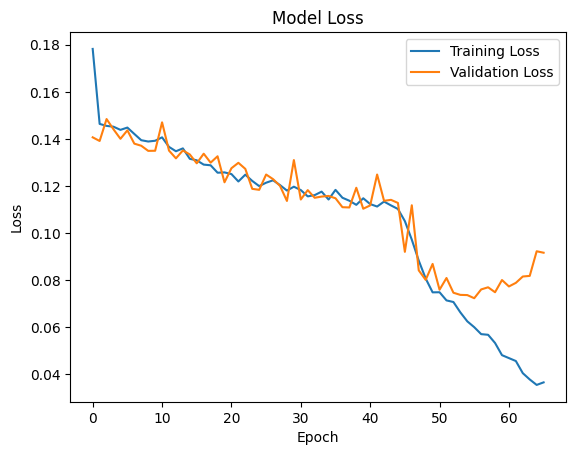

In [ ]:
plt.plot(history_01.history['loss'], label='Training Loss')
plt.plot(history_01.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#y_pred = model.predict(X_test)
y_pred_01 = model_01.predict(X_test)
#y_pred = np.argmax(y_pred, axis=3)
y_pred_01 = np.argmax(y_pred_01, axis=3)
y_test = np.argmax(y_test, axis=3)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 745ms/step


# Prediction and visualization

In [ ]:
test_image_number = 30
print(f'Test image number: {test_image_number}')

Test image number: 30


In [ ]:
test_image = X_test[test_image_number]
ground_truth_image = y_test[test_image_number]
test_image_input = np.expand_dims(test_image, 0)
prediction = model_01.predict(test_image_input)
predicted_image = (prediction > 0.5).astype(np.uint8)
predicted_image = predicted_image[0, :, :, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


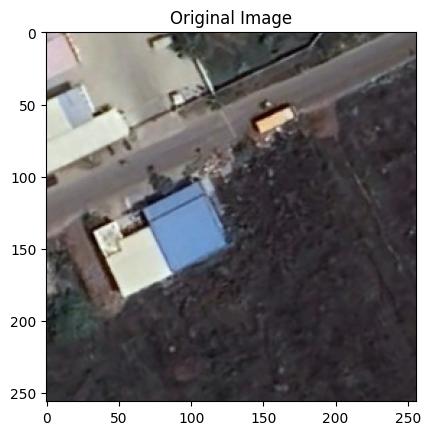

In [ ]:
plt.title("Original Image")
plt.imshow(test_image)
plt.show()

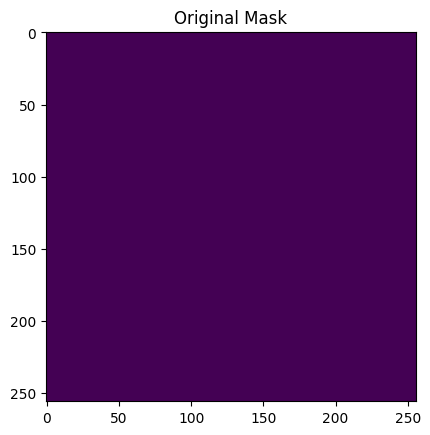

In [ ]:
plt.title("Original Mask")
plt.imshow(ground_truth_image)
plt.show()

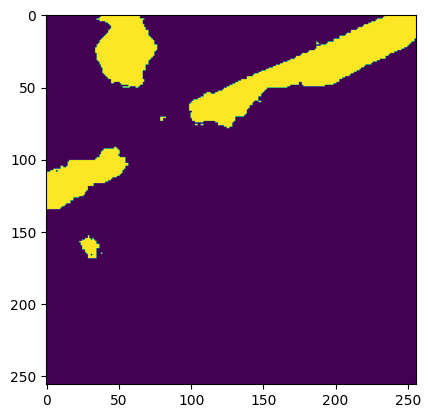

In [ ]:
plt.imshow(predicted_image)
plt.show()

# Model loading and training attention gate

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def jaccard_coef(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + 1.0) / (union + 1.0)

def iou_metric(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + 1e-10) / (union + 1e-10)

def dice_coefficient(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + 1e-10) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + 1e-10)

def precision_metric(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat * y_pred_flat, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred_flat, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall_metric(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat * y_pred_flat, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))



import tensorflow as tf
from tensorflow.keras.layers import Flatten

def calculate_ap(y_true, y_pred, thresholds):
    precisions = []
    recalls = []

    for thresh in thresholds:
        y_pred_thresh = tf.cast(y_pred > thresh, tf.float32)
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_thresh_flat = tf.reshape(y_pred_thresh, [-1])

        true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat * y_pred_thresh_flat, 0, 1)))
        predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred_thresh_flat, 0, 1)))
        possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat, 0, 1)))

        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

        precisions.append(precision)
        recalls.append(recall)

    precisions = tf.stack(precisions)
    recalls = tf.stack(recalls)

    return tf.reduce_mean(precisions), tf.reduce_mean(recalls)

import tensorflow as tf
from tensorflow.keras import backend as K

def mean_average_precision(y_true, y_pred, thresholds=None):
    if thresholds is None:
        thresholds = tf.range(0.0, 1.1, 0.1)

    # Flatten y_true and y_pred
    y_true_flat = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_flat = tf.reshape(y_pred, [-1])

    average_precisions = []

    for threshold in thresholds:
        y_pred_thresh = tf.cast(y_pred_flat > threshold, tf.float32)

        true_positives = K.sum(y_true_flat * y_pred_thresh)
        predicted_positives = K.sum(y_pred_thresh)
        possible_positives = K.sum(y_true_flat)

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        average_precisions.append(precision)

    return K.mean(tf.stack(average_precisions))


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
from tensorflow.keras.models import Model

metrics = [
    "accuracy",
    #jaccard_coef,
    iou_metric,
    dice_coefficient,
    precision_metric,
    recall_metric,
    f1_metric,
    mean_average_precision
]
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, optimizers

def attention_gate(x, g, inter_shape):
    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    add_xg = tf.keras.layers.Add()([theta_x, phi_g])
    relu_xg = tf.keras.layers.Activation('relu')(add_xg)
    psi = Conv2D(1, (1, 1), padding='same')(relu_xg)
    sigmoid_xg = tf.keras.layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(x.shape[1] // shape_sigmoid[1], x.shape[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (K.int_shape(x)[1], K.int_shape(x)[2])))(upsample_psi)
    y = tf.keras.layers.Multiply()([x, upsample_psi])
    result = Conv2D(K.int_shape(x)[-1], (1, 1), padding='same')(y)
    result_bn = tf.keras.layers.BatchNormalization()(result)
    return result_bn

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Compile the model with Nadam optimizer
#model.compile(optimizer=Nadam(learning_rate=0.001)

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
def iou_loss(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_flat * y_pred_flat)
    union = tf.keras.backend.sum(y_true_flat) + tf.keras.backend.sum(y_pred_flat) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou
# Custom Difference Layer using Keras layers
class DifferenceLayer(Layer):
    def __init__(self, **kwargs):
        super(DifferenceLayer, self).__init__(**kwargs)

    def call(self, inputs):
        layer1, layer2 = inputs
        return tf.keras.layers.Subtract()([layer1, layer2])

# Difference Convolution Block using the custom layer
def difference_conv_block(layer1, layer2):
    return DifferenceLayer()([layer1, layer2])

#-----------------------------------------

def simplified_unet_attention(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.25)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.25)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.25)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.25)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.25)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    a4 = attention_gate(c4, c5, 128)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, a4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.25)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    diff_block_1 = difference_conv_block(c6, c4)

    a3 = attention_gate(c3, diff_block_1, 64)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(diff_block_1)
    u7 = concatenate([u7, a3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.25)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    diff_block_2 = difference_conv_block(c7, c3)

    a2 = attention_gate(c2, diff_block_2, 32)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(diff_block_2)
    u8 = concatenate([u8, a2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.25)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    diff_block_3 = difference_conv_block(c8, c2)

    a1 = attention_gate(c1, diff_block_3, 16)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(diff_block_3)
    u9 = concatenate([u9, a1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.25)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)

    return model

model_01 = simplified_unet_attention()
model_01.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 2,095,349 (7.99 MB)

 Trainable params: 2,094,869 (7.99 MB)

 Non-trainable params: 480 (1.88 KB)

In [ ]:
model_01 = simplified_unet_attention(input_size=(256, 256, 3))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=2, restore_best_weights=True)
history_01 = model_01.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8622 - dice_coefficient: 0.0758 - f1_metric: 0.0286 - iou_metric: 0.0395 - loss: 0.3397 - mean_average_precision: 0.0570 - precision_metric: 0.0893 - recall_metric: 0.1117 - val_accuracy: 0.9611 - val_dice_coefficient: 0.0585 - val_f1_metric: 0.0000e+00 - val_iou_metric: 0.0302 - val_loss: 0.4143 - val_mean_average_precision: 0.0142 - val_precision_metric: 0.0000e+00 - val_recall_metric: 0.0000e+00
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 994ms/step - accuracy: 0.9617 - dice_coefficient: 0.0876 - f1_metric: 1.5049e-05 - iou_metric: 0.0459 - loss: 0.1459 - mean_average_precision: 0.0674 - precision_metric: 0.1644 - recall_metric: 7.5248e-06 - val_accuracy: 0.9611 - val_dice_coefficient: 0.0743 - val_f1_metric: 0.0000e+00 - val_iou_metric: 0.0387 - val_loss: 0.3271 - val_mean_average_precision: 0.0283 - val_precision_metric: 0.0000e+00 - val_recall_metric: 0.0000e+00
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - ac

In [ ]:
"""
Epoch 35/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 738ms/step - accuracy: 0.9583 - dice_coefficient: 0.1096 - f1_metric: 0.0000e+00 - iou_metric: 0.0581 - loss: 0.1397 - mean_average_precision: 0.0429 - precision_metric: 0.0000e+00 - recall_metric: 0.0000e+00 - val_accuracy: 0.9611 - val_dice_coefficient: 0.1226 - val_f1_metric: 0.0000e+00 - val_iou_metric: 0.0655 - val_loss: 0.1333 - val_mean_average_precision: 0.0297 - val_precision_metric: 0.0000e+00 - val_recall_metric: 0.0000e+00
Epoch 26/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9719 - dice_coefficient: 0.4135 - f1_metric: 0.5765 - iou_metric: 0.2612 - loss: 0.0751 - mean_average_precision: 0.2976 - precision_metric: 0.7013 - recall_metric: 0.4981 - val_accuracy: 0.9706 - val_dice_coefficient: 0.3633 - val_f1_metric: 0.4731 - val_iou_metric: 0.2241 - val_loss: 0.0791 - val_mean_average_precision: 0.3185 - val_precision_metric: 0.7063 - val_recall_metric: 0.3675
157
Epoch 28/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 80s 953ms/step - accuracy: 0.9767 - dice_coefficient: 0.5473 - f1_metric: 0.6515 - iou_metric: 0.3785 - loss: 0.0602 - mean_average_precision: 0.6086 - precision_metric: 0.7603 - recall_metric: 0.5803 - val_accuracy: 0.9743 - val_dice_coefficient: 0.4635 - val_f1_metric: 0.5661 - val_iou_metric: 0.3055 - val_loss: 0.0723 - val_mean_average_precision: 0.5661 - val_precision_metric: 0.7342 - val_recall_metric: 0.4844
410
Epoch 23/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 965ms/step - accuracy: 0.9753 - dice_coefficient: 0.4930 - f1_metric: 0.6108 - iou_metric: 0.3296 - loss: 0.0648 - mean_average_precision: 0.5830 - precision_metric: 0.7259 - recall_metric: 0.5433 - val_accuracy: 0.9732 - val_dice_coefficient: 0.4481 - val_f1_metric: 0.5021 - val_iou_metric: 0.2923 - val_loss: 0.0917 - val_mean_average_precision: 0.6413 - val_precision_metric: 0.7866 - val_recall_metric: 0.3790
----------
Epoch 71/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 937ms/step - accuracy: 0.9891 - dice_coefficient: 0.8305 - f1_metric: 0.8385 - iou_metric: 0.7108 - loss: 0.1681 - mean_average_precision: 0.6952 - precision_metric: 0.8469 - recall_metric: 0.8317 - val_accuracy: 0.9763 - val_dice_coefficient: 0.6464 - val_f1_metric: 0.6522 - val_iou_metric: 0.4879 - val_loss: 0.2992 - val_mean_average_precision: 0.5373 - val_precision_metric: 0.6533 - val_recall_metric: 0.6827
Epoch 30/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 973ms/step - accuracy: 0.9739 - dice_coefficient: 0.6207 - f1_metric: 0.6452 - iou_metric: 0.4520 - loss: 0.3220 - mean_average_precision: 0.5403 - precision_metric: 0.6532 - recall_metric: 0.6476 - val_accuracy: 0.9744 - val_dice_coefficient: 0.6014 - val_f1_metric: 0.6218 - val_iou_metric: 0.4396 - val_loss: 0.3162 - val_mean_average_precision: 0.5261 - val_precision_metric: 0.6352 - val_recall_metric: 0.6340
Epoch 35/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 948ms/step - accuracy: 0.9800 - dice_coefficient: 0.7175 - f1_metric: 0.7342 - iou_metric: 0.5612 - loss: 0.2600 - mean_average_precision: 0.6294 - precision_metric: 0.7644 - recall_metric: 0.7198 - val_accuracy: 0.9735 - val_dice_coefficient: 0.6279 - val_f1_metric: 0.6327 - val_iou_metric: 0.4654 - val_loss: 0.3214 - val_mean_average_precision: 0.5005 - val_precision_metric: 0.6070 - val_recall_metric: 0.6875
----------------
Epoch 32/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 991ms/step - accuracy: 0.9787 - dice_coefficient: 0.5837 - f1_metric: 0.6804 - iou_metric: 0.4136 - loss: 0.0542 - mean_average_precision: 0.6197 - precision_metric: 0.7749 - recall_metric: 0.6160 - val_accuracy: 0.9765 - val_dice_coefficient: 0.5624 - val_f1_metric: 0.6259 - val_iou_metric: 0.3971 - val_loss: 0.0706 - val_mean_average_precision: 0.5944 - val_precision_metric: 0.7196 - val_recall_metric: 0.5715
"""

'\nEpoch 35/100\n41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 738ms/step - accuracy: 0.9583 - dice_coefficient: 0.1096 - f1_metric: 0.0000e+00 - iou_metric: 0.0581 - loss: 0.1397 - mean_average_precision: 0.0429 - precision_metric: 0.0000e+00 - recall_metric: 0.0000e+00 - val_accuracy: 0.9611 - val_dice_coefficient: 0.1226 - val_f1_metric: 0.0000e+00 - val_iou_metric: 0.0655 - val_loss: 0.1333 - val_mean_average_precision: 0.0297 - val_precision_metric: 0.0000e+00 - val_recall_metric: 0.0000e+00\nEpoch 26/100\n41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9719 - dice_coefficient: 0.4135 - f1_metric: 0.5765 - iou_metric: 0.2612 - loss: 0.0751 - mean_average_precision: 0.2976 - precision_metric: 0.7013 - recall_metric: 0.4981 - val_accuracy: 0.9706 - val_dice_coefficient: 0.3633 - val_f1_metric: 0.4731 - val_iou_metric: 0.2241 - val_loss: 0.0791 - val_mean_average_precision: 0.3185 - val_precision_metric: 0.7063 - val_recall_metric: 0.3675\n157\nEpoch 28/100\n41/41 ━━━━━━━━━━━━━━━━━━━━ 80s 953m

In [ ]:
"""
Epoch 39/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 957ms/step
 accuracy: 0.9610 - dice_coefficient: 0.5653 - f1_metric: 0.6684 - iou_metric: 0.3944 - loss: 0.0972 - mean_average_precision: 0.6161 - precision_metric: 0.7770 - recall_metric: 0.5889
 val_accuracy: 0.9536 - val_dice_coefficient: 0.5179 - val_f1_metric: 0.5954 - val_iou_metric: 0.3517 - val_loss: 0.1205 - val_mean_average_precision: 0.5997 - val_precision_metric: 0.7537 - val_recall_metric: 0.4978

Epoch 49/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 921ms/step - accuracy: 0.9584 - dice_coefficient: 0.5323 - f1_metric: 0.6255 - iou_metric: 0.3640 - loss: 0.1044 -
mean_average_precision: 0.6123 - precision_metric: 0.7729 - recall_metric: 0.5293 - val_accuracy: 0.9518 - val_dice_coefficient: 0.5032 -
val_f1_metric: 0.5464 - val_iou_metric: 0.3369 - val_loss: 0.1276 - val_mean_average_precision: 0.6043 - val_precision_metric: 0.7457 - val_recall_metric: 0.4339

"""
"""
dropout 0.1
Epoch 36/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 987ms/step
accuracy: 0.9807 - dice_coefficient: 0.6396 - f1_metric: 0.7389 - iou_metric: 0.4720 - loss: 0.0482 - mean_average_precision: 0.6422 - precision_metric: 0.8023 - recall_metric: 0.6896
val_accuracy: 0.9742 - val_dice_coefficient: 0.5679 - val_f1_metric: 0.6407 - val_iou_metric: 0.4022 - val_loss: 0.0718 - val_mean_average_precision: 0.5203 - val_precision_metric: 0.6275 - val_recall_metric: 0.6848
dropout 0.2
Epoch 20/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step
accuracy: 0.9733 - dice_coefficient: 0.4574 - f1_metric: 0.5662 - iou_metric: 0.2993 - loss: 0.0709 - mean_average_precision: 0.5798 - precision_metric: 0.7264 - recall_metric: 0.4779
val_accuracy: 0.9728 - val_dice_coefficient: 0.4716 - val_f1_metric: 0.5588 - val_iou_metric: 0.3124 - val_loss: 0.0758 - val_mean_average_precision: 0.5569 - val_precision_metric: 0.6705 - val_recall_metric: 0.4928
"""
"""
l1 and l2 = 0.1
Epoch 40/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9771 - dice_coefficient: 0.5763 - f1_metric: 0.6934 - iou_metric: 0.4057 - loss: 0.0587 - mean_average_precision: 0.6130 - precision_metric: 0.7585 - recall_metric: 0.6440 - val_accuracy: 0.9738 - val_dice_coefficient: 0.4649 - val_f1_metric: 0.5890 - val_iou_metric: 0.3078 - val_loss: 0.0727 - val_mean_average_precision: 0.5557 - val_precision_metric: 0.6648 - val_recall_metric: 0.5490

"""
"""
latest update :
dropout 0.25
Epoch 27/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 985ms/step - accuracy: 0.9779 - dice_coefficient: 0.5850 - f1_metric: 0.6895 - iou_metric: 0.4153 - loss: 0.0566 - mean_average_precision: 0.6109 - precision_metric: 0.7587 - recall_metric: 0.6394 - val_accuracy: 0.9757 - val_dice_coefficient: 0.4772 - val_f1_metric: 0.5732 - val_iou_metric: 0.3183 - val_loss: 0.0717 - val_mean_average_precision: 0.6027 - val_precision_metric: 0.7621 - val_recall_metric: 0.4815
dropout 0.2
Epoch 24/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 963ms/step - accuracy: 0.9743 - dice_coefficient: 0.4817 - f1_metric: 0.6010 - iou_metric: 0.3187 - loss: 0.0673 - mean_average_precision: 0.5870 - precision_metric: 0.7259 - recall_metric: 0.5256 - val_accuracy: 0.9727 - val_dice_coefficient: 0.4720 - val_f1_metric: 0.5788 - val_iou_metric: 0.3151 - val_loss: 0.0753 - val_mean_average_precision: 0.5125 - val_precision_metric: 0.6344 - val_recall_metric: 0.5592
dropout 0.3
Epoch 50/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 946ms/step - accuracy: 0.9783 - dice_coefficient: 0.7255 - f1_metric: 0.7255 - iou_metric: 0.5703 - loss: 0.4297 - mean_average_precision: 0.6336 - precision_metric: 0.7221 - recall_metric: 0.7317 - val_accuracy: 0.9744 - val_dice_coefficient: 0.6374 - val_f1_metric: 0.6374 - val_iou_metric: 0.4767 - val_loss: 0.4965 - val_mean_average_precision: 0.5451 - val_precision_metric: 0.6224 - val_recall_metric: 0.6797 - learning_rate: 5.0000e-04
Epoch 27/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 996ms/step - accuracy: 0.9742 - dice_coefficient: 0.5114 - f1_metric: 0.6246 - iou_metric: 0.3450 - loss: 0.0654 - mean_average_precision: 0.5961 - precision_metric: 0.7359 - recall_metric: 0.5639 - val_accuracy: 0.9724 - val_dice_coefficient: 0.4968 - val_f1_metric: 0.5876 - val_iou_metric: 0.3371 - val_loss: 0.0741 - val_mean_average_precision: 0.5151 - val_precision_metric: 0.6073 - val_recall_metric: 0.6033 - learning_rate: 0.0010
------------------
Epoch 37/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 988ms/step - accuracy: 0.9788 - dice_coefficient: 0.5709 - f1_metric: 0.6758 - iou_metric: 0.4029 - loss: 0.0549 - mean_average_precision: 0.6182 - precision_metric: 0.7834 - recall_metric: 0.6146 - val_accuracy: 0.9752 - val_dice_coefficient: 0.5001 - val_f1_metric: 0.5988 - val_iou_metric: 0.3397 - val_loss: 0.0690 - val_mean_average_precision: 0.5746 - val_precision_metric: 0.6973 - val_recall_metric: 0.5576
"""

'\nlatest update :\ndropout 0.25\nEpoch 27/100\n41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 985ms/step - accuracy: 0.9779 - dice_coefficient: 0.5850 - f1_metric: 0.6895 - iou_metric: 0.4153 - loss: 0.0566 - mean_average_precision: 0.6109 - precision_metric: 0.7587 - recall_metric: 0.6394 - val_accuracy: 0.9757 - val_dice_coefficient: 0.4772 - val_f1_metric: 0.5732 - val_iou_metric: 0.3183 - val_loss: 0.0717 - val_mean_average_precision: 0.6027 - val_precision_metric: 0.7621 - val_recall_metric: 0.4815\ndropout 0.2\nEpoch 24/100\n41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 963ms/step - accuracy: 0.9743 - dice_coefficient: 0.4817 - f1_metric: 0.6010 - iou_metric: 0.3187 - loss: 0.0673 - mean_average_precision: 0.5870 - precision_metric: 0.7259 - recall_metric: 0.5256 - val_accuracy: 0.9727 - val_dice_coefficient: 0.4720 - val_f1_metric: 0.5788 - val_iou_metric: 0.3151 - val_loss: 0.0753 - val_mean_average_precision: 0.5125 - val_precision_metric: 0.6344 - val_recall_metric: 0.5592\ndropout 0.3\nEpoch 50/100\n41/4

In [ ]:
model_01.save('model_attention_01.h5')

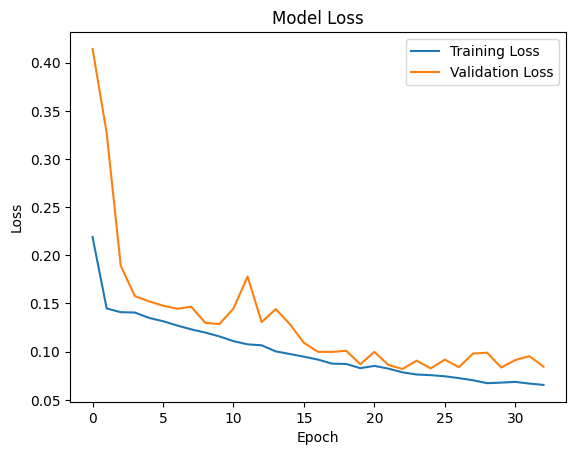

In [ ]:
plt.plot(history_01.history['loss'], label='Training Loss')
plt.plot(history_01.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model_01.predict(X_test)
y_pred = np.argmax(y_pred, axis=3)
y_test = np.argmax(y_test, axis=3)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


# Model loading and training Unet

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def jaccard_coef(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + 1.0) / (union + 1.0)

def iou_metric(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + 1e-10) / (union + 1e-10)

def dice_coefficient(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + 1e-10) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + 1e-10)

def precision_metric(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat * y_pred_flat, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred_flat, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall_metric(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat * y_pred_flat, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Attention Gate block
def attention_gate(x, g, inter_shape):
    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    concat_xg = tf.keras.layers.Add()([theta_x, phi_g])
    act_xg = tf.keras.layers.Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tf.keras.layers.Activation('sigmoid')(psi)
    upsample_psi = UpSampling2D(size=(2, 2))(sigmoid_xg)
    attn_coefficients = tf.keras.layers.Multiply()([upsample_psi, x])
    result = Conv2D(x.shape[-1], (1, 1), padding='same')(attn_coefficients)
    return result


import tensorflow as tf
from tensorflow.keras.layers import Flatten

def calculate_ap(y_true, y_pred, thresholds):
    precisions = []
    recalls = []

    for thresh in thresholds:
        y_pred_thresh = tf.cast(y_pred > thresh, tf.float32)
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_thresh_flat = tf.reshape(y_pred_thresh, [-1])

        true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat * y_pred_thresh_flat, 0, 1)))
        predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred_thresh_flat, 0, 1)))
        possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat, 0, 1)))

        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

        precisions.append(precision)
        recalls.append(recall)

    precisions = tf.stack(precisions)
    recalls = tf.stack(recalls)

    return tf.reduce_mean(precisions), tf.reduce_mean(recalls)

import tensorflow as tf
from tensorflow.keras import backend as K

def mean_average_precision(y_true, y_pred, thresholds=None):
    if thresholds is None:
        thresholds = tf.range(0.0, 1.1, 0.1)

    # Flatten y_true and y_pred
    y_true_flat = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_flat = tf.reshape(y_pred, [-1])

    average_precisions = []

    for threshold in thresholds:
        y_pred_thresh = tf.cast(y_pred_flat > threshold, tf.float32)

        true_positives = K.sum(y_true_flat * y_pred_thresh)
        predicted_positives = K.sum(y_pred_thresh)
        possible_positives = K.sum(y_true_flat)

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        average_precisions.append(precision)

    return K.mean(tf.stack(average_precisions))


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate, Layer
from tensorflow.keras.models import Model

# Custom Difference Layer using Keras layers
class DifferenceLayer(Layer):
    def __init__(self, **kwargs):
        super(DifferenceLayer, self).__init__(**kwargs)

    def call(self, inputs):
        layer1, layer2 = inputs
        return tf.keras.layers.Subtract()([layer1, layer2])
"""
# PSNR Metric Calculation
def psnr(y_true, y_pred):
    max_pixel = 1.0  # Assuming pixel values are normalized to the range [0, 1]
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)"""

# Function for difference convolution block
def difference_conv_block(layer1, layer2):
    return DifferenceLayer()([layer1, layer2])

import tensorflow as tf

# Dice Loss function
def dice_loss(y_true, y_pred, smooth=1):
    # Flatten the tensors
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_score = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

    return 1 - dice_score
def simplified_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Down-sampling path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.07)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.07)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.07)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.07)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.07)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Up-sampling path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.07)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.07)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.07)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.07)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=metrics)

    return model




from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(y_true, y_pred):
    y_true, y_pred =  y_true.numpy(), y_pred.numpy()
    return psnr(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

def calculate_ssim(y_true, y_pred, win_size=7):
    y_true, y_pred =  y_true.numpy(), y_pred.numpy()
    return ssim(y_true, y_pred, win_size=win_size, channel_axis=-1, data_range=y_pred.max() - y_pred.min())
# Define metrics including PSNR
metrics = [
    "accuracy",
    iou_metric,
    dice_coefficient,
    precision_metric,
    recall_metric,
    f1_metric,
    mean_average_precision,
    calculate_psnr,
    calculate_ssim
]
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    smooth = 1e-6
    true_pos = K.sum(y_true * y_pred)
    false_neg = K.sum(y_true * (1 - y_pred))
    false_pos = K.sum((1 - y_true) * y_pred)
    return 1 - (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)


In [ ]:
def boundary_loss():
  def boundary_loss_fixed(y_true,y_pred):
    # Gradient of the ground truth (edges of true mask)
    y_true_grad = tf.image.sobel_edges(y_true)
    y_pred_grad = tf.image.sobel_edges(y_pred)

    # L1 loss between gradients of true and predicted edges
    grad_loss = tf.reduce_mean(tf.abs(y_true_grad - y_pred_grad))
    return grad_loss
  return boundary_loss_fixed
def boundary_loss_fixed_st(y_true,y_pred):
    # Gradient of the ground truth (edges of true mask)
    y_true_grad = tf.image.sobel_edges(y_true)
    y_pred_grad = tf.image.sobel_edges(y_pred)

    # L1 loss between gradients of true and predicted edges
    grad_loss = tf.reduce_mean(tf.abs(y_true_grad - y_pred_grad))
    return grad_loss
import tensorflow as tf

import tensorflow as tf

def iou_loss(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_flat * y_pred_flat)
    union = tf.keras.backend.sum(y_true_flat) + tf.keras.backend.sum(y_pred_flat) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)

        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = -alpha_t * tf.pow((1. - p_t), gamma) * tf.math.log(p_t)
        return tf.reduce_mean(fl)
    return focal_loss_fixed
def combined_loss():
  def combined_loss_fixed(y_true, y_pred):
    focal = focal_loss(gamma=2., alpha=0.25)(y_true, y_pred)
    boundary = boundary_loss_fixed_st(y_true, y_pred)
    return focal + 0.5 * boundary
  return combined_loss_fixed

def get_deep_learning_model():
    model = simplified_unet()
    model.compile(optimizer="adam", loss=iou_loss, metrics=metrics)
    return model


In [ ]:
model = get_deep_learning_model()
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=2, restore_best_weights=True)
#model.compile(optimizer="adam", loss='binary_crossentropy', metrics=metrics)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.0852 - calculate_psnr: -6.5920 - calculate_ssim: 0.0120 - dice_coefficient: 0.0826 - f1_metric: 0.0826 - iou_metric: 0.0432 - loss: 0.9568 - mean_average_precision: 0.0410 - precision_metric: 0.0434 - recall_metric: 0.9876 - val_accuracy: 0.4261 - val_calculate_psnr: 2.3987 - val_calculate_ssim: 0.0295 - val_dice_coefficient: 0.0999 - val_f1_metric: 0.1059 - val_iou_metric: 0.0529 - val_loss: 0.9434 - val_mean_average_precision: 0.0481 - val_precision_metric: 0.0564 - val_recall_metric: 0.9498
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6189 - calculate_psnr: 5.7337 - calculate_ssim: 0.1723 - dice_coefficient: 0.1113 - f1_metric: 0.1127 - iou_metric: 0.0598 - loss: 0.9402 - mean_average_precision: 0.0643 - precision_metric: 0.0752 - recall_metric: 0.6794 - val_accuracy: 0.4967 - val_calculate_psnr: 3.0531 - val_calculate_ssim: 0.0381 - val_dice_coefficient: 0.1158 - val_f1_metric: 0.1160 - val_iou_met

/usr/local/lib/python3.10/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range**2) / err)


20/41 ━━━━━━━━━━━━━━━━━━━━ 18s 864ms/step - accuracy: 0.0481 - calculate_psnr: -inf - calculate_ssim: nan - dice_coefficient: 0.0835 - f1_metric: 0.0835 - iou_metric: 0.0437 - loss: 0.9563 - mean_average_precision: 0.0397 - precision_metric: 0.0437 - recall_metric: 0.9998      

/usr/local/lib/python3.10/dist-packages/skimage/metrics/_structural_similarity.py:269: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 948ms/step - accuracy: 0.0456 - calculate_psnr: -inf - calculate_ssim: nan - dice_coefficient: 0.0796 - f1_metric: 0.0796 - iou_metric: 0.0416 - loss: 0.9584 - mean_average_precision: 0.0378 - precision_metric: 0.0416 - recall_metric: 0.9995 - val_accuracy: 0.0418 - val_calculate_psnr: -inf - val_calculate_ssim: nan - val_dice_coefficient: 0.0697 - val_f1_metric: 0.0697 - val_iou_metric: 0.0362 - val_loss: 0.9611 - val_mean_average_precision: 0.0329 - val_precision_metric: 0.0362 - val_recall_metric: 0.9980
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 989ms/step - accuracy: 0.0388 - calculate_psnr: -inf - calculate_ssim: nan - dice_coefficient: 0.0717 - f1_metric: 0.0717 - iou_metric: 0.0373 - loss: 0.9627 - mean_average_precision: 0.0339 - precision_metric: 0.0373 - recall_metric: 0.9998 - val_accuracy: 0.0410 - val_calculate_psnr: -inf - val_calculate_ssim: nan - val_dice_coefficient: 0.0698 - val_f1_metric: 0.0698 - val_iou_metric: 0.0363 - val_loss: 0.9

In [ ]:
"""
Epoch 22/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 539ms/step
accuracy: 0.9809 - dice_coefficient: 0.6105 - f1_metric: 0.7194 - iou_metric: 0.4409 - loss: 0.0495 - mean_average_precision: 0.6387 - precision_metric: 0.7963 - recall_metric: 0.6607
val_accuracy: 0.9745 - val_dice_coefficient: 0.4977 - val_f1_metric: 0.6001 - val_iou_metric: 0.3363 - val_loss: 0.0749 - val_mean_average_precision: 0.5549 - val_precision_metric: 0.6739 - val_recall_metric: 0.5671
Epoch 28/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 37s 449ms/step
accuracy: 0.9822 - dice_coefficient: 0.6553 - f1_metric: 0.7509 - iou_metric: 0.4902 - loss: 0.0439 - mean_average_precision: 0.6459 - precision_metric: 0.8001 - recall_metric: 0.7172
val_accuracy: 0.9739 - val_dice_coefficient: 0.5180 - val_f1_metric: 0.6022 - val_iou_metric: 0.3573 - val_loss: 0.0734 - val_mean_average_precision: 0.5432 - val_precision_metric: 0.6582 - val_recall_metric: 0.5738
"""
"""
Epoch 14/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 556ms/step - accuracy: 0.9627 - dice_coefficient: 0.1127 - f1_metric: 1.1478e-05 - iou_metric: 0.0598 - loss: 0.1337 - mean_average_precision: 0.0957 - precision_metric: 0.0772 - recall_metric: 5.7394e-06 - val_accuracy: 0.9611 - val_dice_coefficient: 0.1115 - val_f1_metric: 0.0000e+00 - val_iou_metric: 0.0593 - val_loss: 0.1428 - val_mean_average_precision: 0.0597 - val_precision_metric: 0.0000e+00 - val_recall_metric: 0.0000e+00
Epoch 14/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 551ms/step - accuracy: 0.9615 - dice_coefficient: 0.1019 - f1_metric: 4.5883e-05 - iou_metric: 0.0538 - loss: 0.1439 - mean_average_precision: 0.0950 - precision_metric: 0.1839 - psnr: -24.0553 - recall_metric: 2.2945e-05 - val_accuracy: 0.9611 - val_dice_coefficient: 0.0570 - val_f1_metric: 0.0000e+00 - val_iou_metric: 0.0294 - val_loss: 0.1803 - val_mean_average_precision: 0.0439 - val_precision_metric: 0.0000e+00 - val_psnr: -14.8264 - val_recall_metric: 0.0000e+00
"""
"""
Epoch 32/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 533ms/step - accuracy: 0.9826 - dice_coefficient: 0.6432 - f1_metric: 0.7448 - iou_metric: 0.4753 - loss: 0.0442 - mean_average_precision: 0.6524 - precision_metric: 0.8155 - psnr: -19.6015 - recall_metric: 0.6906 - val_accuracy: 0.9708 - val_dice_coefficient: 0.4418 - val_f1_metric: 0.5415 - val_iou_metric: 0.2877 - val_loss: 0.0905 - val_mean_average_precision: 0.5155 - val_precision_metric: 0.6213 - val_psnr: -22.7468 - val_recall_metric: 0.5033
Epoch 24/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 535ms/step - accuracy: 0.0388 - dice_coefficient: 0.0746 - f1_metric: 0.0746 - iou_metric: 0.0388 - loss: 0.0632 - mean_average_precision: 0.0353 - precision_metric: 0.0388 - psnr: -48.1295 - recall_metric: 1.0000 - val_accuracy: 0.0389 - val_dice_coefficient: 0.0697 - val_f1_metric: 0.0697 - val_iou_metric: 0.0362 - val_loss: 0.0744 - val_mean_average_precision: 0.0329 - val_precision_metric: 0.0362 - val_psnr: -48.1295 - val_recall_metric: 1.0000
"""
"""
focal_loss
Epoch 28/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 527ms/step - accuracy: 0.9743 - dice_coefficient: 0.3194 - f1_metric: 0.5214 - iou_metric: 0.1916 - loss: 0.0056 - mean_average_precision: 0.6201 - precision_metric: 0.9206 - psnr: -26.9596 - recall_metric: 0.3774 - val_accuracy: 0.9729 - val_dice_coefficient: 0.2515 - val_f1_metric: 0.5133 - val_iou_metric: 0.1454 - val_loss: 0.0077 - val_mean_average_precision: 0.5084 - val_precision_metric: 0.7621 - val_psnr: -28.4708 - val_recall_metric: 0.4051
boundary_loss
Epoch 17/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 553ms/step - accuracy: 0.9602 - dice_coefficient: 0.0734 - f1_metric: 5.8512e-06 - iou_metric: 0.0382 - loss: 0.0207 - mean_average_precision: 0.0242 - precision_metric: 0.0673 - psnr: -42.0413 - recall_metric: 2.9257e-06 - val_accuracy: 0.9611 - val_dice_coefficient: 0.0671 - val_f1_metric: 0.0000e+00 - val_iou_metric: 0.0348 - val_loss: 0.0214 - val_mean_average_precision: 0.0165 - val_precision_metric: 0.0000e+00 - val_psnr: -42.0414 - val_recall_metric: 0.0000e+00
"""
"""
focal_loss
Epoch 19/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 913ms/step - accuracy: 0.9708 - calculate_psnr: 15.0943 - calculate_ssim: 0.1703 - dice_coefficient: 0.2695 - f1_metric: 0.4631 - iou_metric: 0.1564 - loss: 0.0070 - mean_average_precision: 0.5595 - precision_metric: 0.8715 - recall_metric: 0.3308 - val_accuracy: 0.9687 - val_calculate_psnr: 13.3425 - val_calculate_ssim: 0.1272 - val_dice_coefficient: 0.2091 - val_f1_metric: 0.3488 - val_iou_metric: 0.1181 - val_loss: 0.0086 - val_mean_average_precision: 0.3942 - val_precision_metric: 0.8019 - val_recall_metric: 0.2302
dice_loss
Epoch 39/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 942ms/step - accuracy: 0.9805 - calculate_psnr: 17.2359 - calculate_ssim: 0.8150 - dice_coefficient: 0.7312 - f1_metric: 0.7312 - iou_metric: 0.5778 - loss: 0.2689 - mean_average_precision: 0.6301 - precision_metric: 0.7561 - recall_metric: 0.7126 - val_accuracy: 0.9725 - val_calculate_psnr: 15.6539 - val_calculate_ssim: 0.7548 - val_dice_coefficient: 0.5952 - val_f1_metric: 0.5953 - val_iou_metric: 0.4342 - val_loss: 0.3733 - val_mean_average_precision: 0.5087 - val_precision_metric: 0.6090 - val_recall_metric: 0.6161
Epoch 40/100
"""
"""
latest
Epoch 45/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 859ms/step - accuracy: 0.9839 - calculate_psnr: 18.0557 - calculate_ssim: 0.8440 - dice_coefficient: 0.7753 - f1_metric: 0.7753 - iou_metric: 0.6344 - loss: 0.3656 - mean_average_precision: 0.6994 - precision_metric: 0.7999 - recall_metric: 0.7563 - val_accuracy: 0.9736 - val_calculate_psnr: 15.9624 - val_calculate_ssim: 0.7630 - val_dice_coefficient: 0.6095 - val_f1_metric: 0.6096 - val_iou_metric: 0.4485 - val_loss: 0.5288 - val_mean_average_precision: 0.5530 - val_precision_metric: 0.6306 - val_recall_metric: 0.6214

"""

'\nlatest\nEpoch 45/100\n41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 859ms/step - accuracy: 0.9839 - calculate_psnr: 18.0557 - calculate_ssim: 0.8440 - dice_coefficient: 0.7753 - f1_metric: 0.7753 - iou_metric: 0.6344 - loss: 0.3656 - mean_average_precision: 0.6994 - precision_metric: 0.7999 - recall_metric: 0.7563 - val_accuracy: 0.9736 - val_calculate_psnr: 15.9624 - val_calculate_ssim: 0.7630 - val_dice_coefficient: 0.6095 - val_f1_metric: 0.6096 - val_iou_metric: 0.4485 - val_loss: 0.5288 - val_mean_average_precision: 0.5530 - val_precision_metric: 0.6306 - val_recall_metric: 0.6214\n\n'

In [ ]:
model.save('model_01.h5')

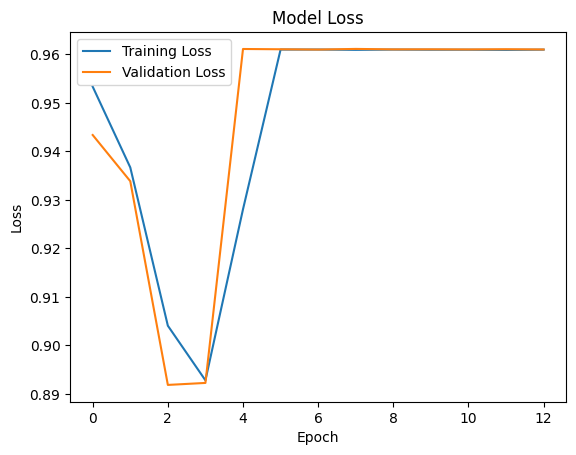

In [ ]:
history = model_history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=3)
y_test = np.argmax(y_test, axis=3)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def jaccard_coef(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + 1.0) / (union + 1.0)

def iou_metric(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + 1e-10) / (union + 1e-10)

def dice_coefficient(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + 1e-10) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + 1e-10)

import tensorflow as tf
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

def precision_metric(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat * y_pred_flat, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred_flat, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall_metric(y_true, y_pred):
    y_true_flat = Flatten()(y_true)
    y_pred_flat = Flatten()(y_pred)

    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat * y_pred_flat, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_flat, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))


import tensorflow as tf
from tensorflow.keras import backend as K

def mean_average_precision(y_true, y_pred, thresholds=None):
    if thresholds is None:
        thresholds = tf.range(0.0, 1.1, 0.1)

    # Flatten y_true and y_pred
    y_true_flat = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_flat = tf.reshape(y_pred, [-1])

    average_precisions = []

    for threshold in thresholds:
        y_pred_thresh = tf.cast(y_pred_flat > threshold, tf.float32)

        true_positives = K.sum(y_true_flat * y_pred_thresh)
        predicted_positives = K.sum(y_pred_thresh)
        possible_positives = K.sum(y_true_flat)

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        average_precisions.append(precision)

    return K.mean(tf.stack(average_precisions))



In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
from tensorflow.keras.models import Model


metrics = [
    "accuracy",
    #jaccard_coef,
    iou_metric,
    dice_coefficient,
    precision_metric,
    recall_metric,
    mean_average_precision
]

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Add
from tensorflow.keras.models import Model

def fcn8(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)

    # Decoder
    up5 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv4)
    up5 = Add()([up5, conv3])  # Skip connection

    up6 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(up5)
    up6 = Add()([up6, conv2])  # Skip connection

    up7 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(up6)
    up7 = Add()([up7, conv1])  # Skip connection

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(up7)

    model = Model(inputs, outputs)
    return model

model_01 = fcn8(input_shape=(256, 256, 3), num_classes=1)
model_01.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
model_01.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │      1,179,904 │ conv2d_3[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 256)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 128, 128, 128)  │        295,040 │ add[0][0]              │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 128, 128, 128)  │              0 │ conv2d_transpose_1[0]… │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 256, 256, 64)   │         73,792 │ add_1[0][0]            │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256, 256, 64)   │              0 │ conv2d_transpose_2[0]… │
│                           │                        │                │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 1)    │             65 │ add_2[0][0]            │
└──────────────────────

 Total params: 3,099,777 (11.82 MB)

 Trainable params: 3,099,777 (11.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=2, restore_best_weights=True)
history_01 = model_01.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 48s 882ms/step - accuracy: 0.9641 - dice_coefficient: 0.0313 - iou_metric: 0.0159 - loss: 0.3259 - mean_average_precision: 0.0073 - precision_metric: 0.0000e+00 - recall_metric: 0.0000e+00 - val_accuracy: 0.9611 - val_dice_coefficient: 0.0779 - val_iou_metric: 0.0406 - val_loss: 0.1539 - val_mean_average_precision: 0.0178 - val_precision_metric: 0.0000e+00 - val_recall_metric: 0.0000e+00
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 732ms/step - accuracy: 0.9620 - dice_coefficient: 0.0794 - iou_metric: 0.0414 - loss: 0.1456 - mean_average_precision: 0.0247 - precision_metric: 0.0000e+00 - recall_metric: 0.0000e+00 - val_accuracy: 0.9611 - val_dice_coefficient: 0.0841 - val_iou_metric: 0.0440 - val_loss: 0.1404 - val_mean_average_precision: 0.0200 - val_precision_metric: 0.0000e+00 - val_recall_metric: 0.0000e+00
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 728ms/step - accuracy: 0.9603 - dice_coefficient: 0.0904 - iou_metric: 0.0474 - loss: 0.1459 - me

In [ ]:
"""
Epoch 47/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 707ms/step
accuracy: 0.9516 - dice_coefficient: 0.4680 - iou_metric: 0.3063 - loss: 0.1268 - mean_average_precision: 0.5807 - precision_metric: 0.7245 - recall_metric: 0.4734
val_accuracy: 0.9488 - val_dice_coefficient: 0.4501 - val_iou_metric: 0.2918 - val_loss: 0.1331 - val_mean_average_precision: 0.5661 - val_precision_metric: 0.7101 - val_recall_metric: 0.4346

65/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 712ms/step - accuracy: 0.9576 - dice_coefficient: 0.5363 - iou_metric: 0.3671 - loss: 0.1086 -
mean_average_precision: 0.6180 - precision_metric: 0.7746 - recall_metric: 0.5420 - val_accuracy: 0.9478 -
val_dice_coefficient: 0.4767 - val_iou_metric: 0.3130 - val_loss: 0.1378 - val_mean_average_precision: 0.5493 -
val_precision_metric: 0.6718 - val_recall_metric: 0.4652

Epoch 68/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 675ms/step - accuracy: 0.9557 - dice_coefficient: 0.5260 - iou_metric: 0.3575 - loss: 0.1145
- mean_average_precision: 0.6091 - precision_metric: 0.7643 - recall_metric: 0.5362
val_accuracy: 0.9479 - val_dice_coefficient: 0.4701 - val_iou_metric: 0.3076 - val_loss: 0.1370 - val_mean_average_precision: 0.5478 - val_precision_metric: 0.6695
 - val_recall_metric: 0.4587

"""
"""
Epoch 53/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 718ms/step - accuracy: 0.9767 - dice_coefficient: 0.5299 - iou_metric: 0.3621 - loss: 0.0619 - mean_average_precision: 0.6201 - precision_metric: 0.7856 - recall_metric: 0.5343 - val_accuracy: 0.9730 - val_dice_coefficient: 0.4548 - val_iou_metric: 0.3079 - val_loss: 0.0785 - val_mean_average_precision: 0.5507 - val_precision_metric: 0.6959 - val_recall_metric: 0.4782
"""

'\nEpoch 47/100\n19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 707ms/step\naccuracy: 0.9516 - dice_coefficient: 0.4680 - iou_metric: 0.3063 - loss: 0.1268 - mean_average_precision: 0.5807 - precision_metric: 0.7245 - recall_metric: 0.4734\nval_accuracy: 0.9488 - val_dice_coefficient: 0.4501 - val_iou_metric: 0.2918 - val_loss: 0.1331 - val_mean_average_precision: 0.5661 - val_precision_metric: 0.7101 - val_recall_metric: 0.4346\n\n65/100\n17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 712ms/step - accuracy: 0.9576 - dice_coefficient: 0.5363 - iou_metric: 0.3671 - loss: 0.1086 -\nmean_average_precision: 0.6180 - precision_metric: 0.7746 - recall_metric: 0.5420 - val_accuracy: 0.9478 -\nval_dice_coefficient: 0.4767 - val_iou_metric: 0.3130 - val_loss: 0.1378 - val_mean_average_precision: 0.5493 -\nval_precision_metric: 0.6718 - val_recall_metric: 0.4652\n\nEpoch 68/100\n17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 675ms/step - accuracy: 0.9557 - dice_coefficient: 0.5260 - iou_metric: 0.3575 - loss: 0.1145\n- mean_average_precision:

In [ ]:
model_01.save('model_01.h5')

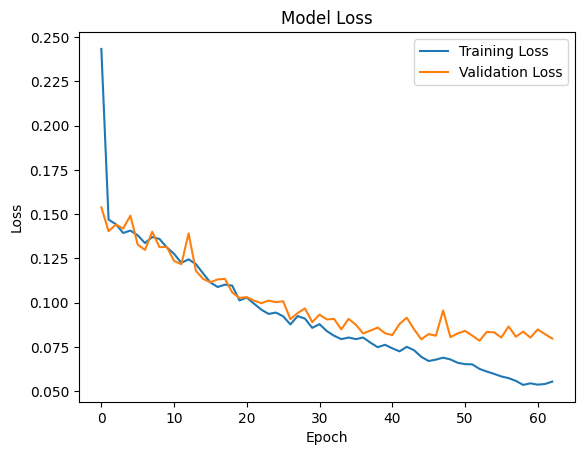

In [ ]:
plt.plot(history_01.history['loss'], label='Training Loss')
plt.plot(history_01.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#y_pred = model.predict(X_test)
y_pred_01 = model_01.predict(X_test)
#y_pred = np.argmax(y_pred, axis=3)
y_pred_01 = np.argmax(y_pred_01, axis=3)
y_test = np.argmax(y_test, axis=3)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step
